# Proof-of-concept: HiTS data ingestion to InfluxDB

In [1]:
import os
import re
import sys
import glob
import time
import tarfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from astropy.table import Table
from influxdb import InfluxDBClient
from scipy.spatial import cKDTree
from astropy.coordinates import SkyCoord
from astropy import units as u
import json

%matplotlib inline

mainpath = '/Users/jorgetil/Astro/HITS'

#from IPython.core.display import display, HTML
#display(HTML("<style>.container { width:100% !important; }</style>"))

In [9]:
field = 'Blind15A_25'
ccd = 'N1'

HiTS_path = '%s/tables/%s_%s_HiTS_10_table.csv' % (mainpath, field, ccd)
HiTS_data = pd.read_csv(HiTS_path)
HiTS_data.drop('Unnamed: 0', axis=1, inplace=True)
HiTS_data.drop_duplicates(subset=['ID'],inplace=True)
HiTS_data.set_index('ID', inplace=True)

In [3]:
print HiTS_data.shape
HiTS_data.head(5)

(2450, 118)


,internalID,X,Y,raMedian,decMedian,raMedianStd,decMedianStd,gN,gFluxRadius,gFWHM,...,iAp4Flux,iAp4FluxErr,iMedianAp4Mag,iMedianAp4MagStd,iMedianAp4MagErr,iAp5Flux,iAp5FluxErr,iMedianAp5Mag,iMedianAp5MagStd,iMedianAp5MagErr
ID,,,,,,,,,,,,,,,,,,,,,
HiTS094609+020352,Blind15A_25_N1_1290_0063,1290.439840,63.272481,146.541617,2.064633,0.000008,0.000007,17,2.6370,4.630,...,351143.100,872.281912,16.020268,0.0,0.029073,358338.700,1088.446419,15.998244,0.0,0.029134
HiTS094609-020754,Blind15A_25_N1_0369_0033,369.793084,33.143914,146.539565,2.131869,0.000019,0.000022,11,3.5520,8.910,...,7654.098,819.898415,20.174243,0.0,0.119851,8232.882,1046.119361,20.095099,0.0,0.140964
HiTS094609+020832,Blind15A_25_N1_0227_0029,227.247369,29.163745,146.539298,2.142279,0.000013,0.000013,14,3.8875,7.015,...,20123.350,821.858432,19.124728,0.0,0.052955,21977.000,1047.813240,19.029057,0.0,0.059309
HiTS094609-020243,Blind15A_25_N1_1553_0030,1553.572814,30.174407,146.539161,2.045425,0.000009,0.000009,18,2.4895,4.630,...,11583.890,820.516637,19.724342,0.0,0.082173,12081.370,1046.593940,19.678688,0.0,0.098410
HiTS094609+020919,Blind15A_25_N1_0048_0024,48.765699,24.877293,146.539015,2.155313,0.000028,0.000020,17,3.8380,11.350,...,5394.736,819.542769,20.554053,0.0,0.167461,5732.633,1045.810926,20.488093,0.0,0.200176


In [10]:
cata_list = np.sort(glob.glob('%s/catalogues/%s/%s/%s_%s_*_image_crblaster_thresh1.0_minarea1_backsize64_final.dat' %
                     (mainpath, field, ccd, field, ccd)))
catalogs = []
epochs = []
filter_list = []
tree_radec = []
tree_pix = []
epochs_g = np.loadtxt('%s/INFO/%s/%s_epochs_g.txt' % (mainpath, field, field))
epochs_r = np.loadtxt('%s/INFO/%s/%s_epochs_r.txt' % (mainpath, field, field))
epochs_i = np.loadtxt('%s/INFO/%s/%s_epochs_i.txt' % (mainpath, field, field))
#print epochs_g
#print epochs_r
#print epochs_i
for file in cata_list:
    epo = file.replace('%s/catalogues/%s/%s/%s_%s_' % (mainpath, field, ccd, field, ccd),'')[:2]
    print '\r', epo,
    band = ''
    if int(epo) in epochs_g[:,0]:
        band = 'g'
        pos = np.where(epochs_g[:,0] == int(epo))[0][0]
        print pos,
        mjd = epochs_g[pos,1]
    elif int(epo) in epochs_r[:,0]:
        band = 'r'
        pos = np.where(epochs_r[:,0] == int(epo))[0][0]
        print pos,
        mjd = epochs_r[pos,1]
    elif int(epo) in epochs_i[:,0]:
        band = 'i'
        pos = np.where(epochs_i[:,0] == int(epo))[0][0]
        print pos,
        mjd = epochs_i[pos,1]
    epochs.append([epo, mjd])
    filter_list.append(band)
    print band
    
    cata_aux = Table.read(file, format = 'ascii')
    catalogs.append(cata_aux)
    
    coord = SkyCoord(ra=cata_aux['RA'].tolist(), dec=cata_aux['DEC'].tolist(),
                    frame='icrs', unit=u.degree)
    tree_radec.append(coord)
    tree_pix.append(cKDTree(np.array([cata_aux['X_IMAGE'].tolist(), cata_aux['Y_IMAGE'].tolist()]).T))

01 0 r
02 0 g
03 1 g
04 2 g
05 3 g
06 4 g
07 5 g
08 6 g
09 7 g
10 8 g
11 9 g
12 10 g
13 11 g
14 12 g
15 13 g
16 14 g
17 15 g
18 16 g
19 17 g
20 18 g
21 19 g
22 20 g
23 21 g
24 1 r
25 22 g
26 23 g
27 2 r
28 24 g
29 25 g
30 0 i
31 3 r
32 26 g
33 4 r
34 1 i
35 27 g


In [5]:
client = InfluxDBClient('localhost', 8086, 'root', 'root', 'HiTS-test')
client.create_database('HiTS-test')

master_name = 'sources'
obs_name = 'obs'

t_0 = time.time()
sources = []
time_index_db = []
delta_obj = 0
count_obs = 0
master_index = 100000 * (int(ccd[1:]) - 1)

for i,idx in enumerate(HiTS_data.index.tolist()):
    print '\r', i, idx,
    #print int(HiTS_data.loc[idx,'gN'] + HiTS_data.loc[idx,'rN'] + HiTS_data.loc[idx,'iN'])
    
    X = HiTS_data.loc[idx,'X']
    Y = HiTS_data.loc[idx,'Y']
    
    obj_serie = []
    count = 0
    times = []
    gN, rN, iN = 0,0,0
    obj_off = 10 * i # offset between object of 10 days
    
    for k, cata in enumerate(catalogs):
        #query = SkyCoord(ra=ra, dec=dec, frame='icrs', unit=u.degree)
        #pos, d2d, d3d = query.match_to_catalog_3d(tree_radec[k])
        
        dist, poss = tree_pix[k].query([X,Y], k = 1, distance_upper_bound = 1)
        #print pos, poss
        #print d2d.arcsec, dist
        
        if poss == len(cata): continue
        count_obs += 1
        master_index += 1
        
        if filter_list[k] == 'g':
            gN += 1
        elif filter_list[k] == 'r':
            rN += 1
        elif filter_list[k] == 'i':
            iN += 1
         
        mjd_idx = epochs[k][1] + int(delta_obj + obj_off)
        times.append(k)
        mjd_idx = 100000 * (int(ccd[1:]) - 1) + k + int(delta_obj + obj_off)
        #print mjd_idx
        time_index_db.append(master_index)
        
        #mjd_idx *= 10**9
        #print int(mjd_idx)
        obj = {"measurement": obs_name,
                "time"    : int(master_index),
                "fields"  :{"mjd": epochs[k][1],
                            "ra" : cata['RA'][poss],
                            "dec": cata['DEC'][poss],
                            "KronMag"   : cata['MAG_AUTO_ZP'][poss],
                            "KronMagErr": cata['MAGERR_AUTO_ZP'][poss],
                            "Flag": cata['FLAGS'][poss]
                            },
                "tags"    :{"ID"     : idx,
                            "filter" : filter_list[k]
                           }
              }
        obj_serie.append(obj)
    client.write_points(obj_serie)
    
    #source = {"measurement": master_name,
    #          "time"       : i+1,
    #          "fields"     :{"ID" : idx,
    #                        "raMedian" : HiTS_data.loc[idx,'raMedian'],
    #                        "decMedian": HiTS_data.loc[idx,'decMedian'],
    #                        "allN"     : count,
    #                        "gN"       : gN,
    #                        "rN"       : rN,
    #                        "iN"       : iN,
    #                        "gMedianKronMag"   : HiTS_data.loc[idx,'gMedianKronMag'],
    #                        "gMedianKronMagErr": HiTS_data.loc[idx,'gMedianKronMagErr']
    #                        },
    #           "tags"    :{"ID" : idx
    #                      }
    #          }
    #sources.append(source)
    #all_times.append(times)
    delta_obj += np.max(times) - np.min(times)
    #print 'elapsed time: ', np.max(times) - np.min(times)
    #print '_______________'
        
        
#client.write_points(sources)
t_1 = time.time()
write_time = (t_1-t_0)
print 'points in obs table: ', count_obs
print("write time: %f" % write_time)

2449 HiTS094707-020059 points in obs table:  25157
write time: 33.755058


In [6]:
print len(np.unique(time_index_db))

25157


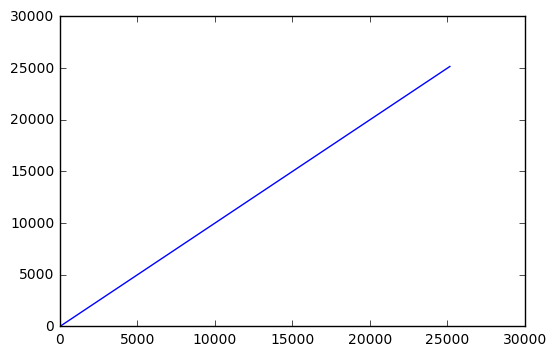

In [7]:
plt.plot(time_index_db, 'b')
plt.show()

# List of typical queries

In [268]:
query_list = ['SELECT * FROM "sources"',
              'SELECT "ID", "KronMag", "filter" FROM "obs"',
              'SELECT * FROM "sources" WHERE "allN" > 25',
              'SELECT * FROM "obs" WHERE "filter" = \'i\'',
              'SELECT MEDIAN("KronMag") AS mea_mag FROM "obs" WHERE "ID" = \'HiTS094609-020243\' AND "Flag" = 0 AND "filter" = \'g\'',
              'select median("KronMag") from "obs" group by *']
measurments = ['sources','obs', 'sources', 'obs', 'obs', 'obs']

for query, measure in zip(query_list, measurments):
    print query
    %time result = client.query(query)
    
    print pd.DataFrame(list(result.get_points(measurement=measure)))
    print '________________________________________________________________________________________'

SELECT * FROM "sources"
CPU times: user 3.76 ms, sys: 1.61 ms, total: 5.38 ms
Wall time: 4.59 ms
                  ID  allN  decMedian  gMedianKronMag  gMedianKronMagErr  gN  \
0  HiTS094609+020352    29   2.064633       17.027848           0.004688  23   
1  HiTS094609-020754    17   2.131869       22.398436           0.161044  13   
2  HiTS094609+020832    22   2.142279       20.384045           0.029973  18   
3  HiTS094609-020243    22   2.045425       20.727168           0.029510  18   
4  HiTS094609+020919    21   2.155313       21.783602           0.093738  17   

   iN  rN    raMedian                            time  
0   1   5  146.541617  1970-01-01T00:00:00.000000001Z  
1   1   3  146.539565  1970-01-01T00:00:00.000000002Z  
2   1   3  146.539298  1970-01-01T00:00:00.000000003Z  
3   1   3  146.539161  1970-01-01T00:00:00.000000004Z  
4   1   3  146.539015  1970-01-01T00:00:00.000000005Z  
______________________________________________________________________________________